# Reddit Image Analysis

### Toolkits

In [130]:
import pandas as pd
import scipy.stats
import pandas as pd
import nltk
import ast
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import spearmanr
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Data Cleaning

In [131]:
# Concatenate
data1 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data1/reddit_scores.csv')
data2 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data2/reddit_scores.csv')
data3 = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/Fetch_Data3/reddit_scores.csv')

In [132]:
raw = pd.concat([data1, data2, data3], ignore_index=True)

In [133]:
raw.describe()

,upvotes,comments,memorability_score,Unnamed: 0
count,1247.00000,1247.000000,1247.000000,376.000000
mean,2391.82518,129.562149,0.746311,187.500000
std,8043.72559,555.583018,0.125758,108.686092
min,4.00000,5.000000,0.412756,0.000000
25%,101.50000,7.000000,0.665339,93.750000
50%,235.00000,11.000000,0.768715,187.500000
75%,400.50000,27.000000,0.842717,281.250000
max,71773.00000,7910.000000,0.980310,375.000000


In [134]:
raw = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/allData_titles.csv')

In [135]:
def remove_outliers_iqr(df, columns):
    outlier_indices = pd.Index([])

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_thresh = Q1 - 1.5 * IQR
        upper_thresh = Q3 + 1.5 * IQR

        column_outliers = df[(df[column] < lower_thresh) | (df[column] > upper_thresh)].index
        outlier_indices = outlier_indices.union(column_outliers)
        
    df_cleaned = df.drop(outlier_indices)

    return outlier_indices, df_cleaned

outlier_indices, df = remove_outliers_iqr(raw, ['upvotes', 'comments'])


In [136]:
df['id'] = df['id'].astype(str)

Text(0, 0.5, 'Frequency')

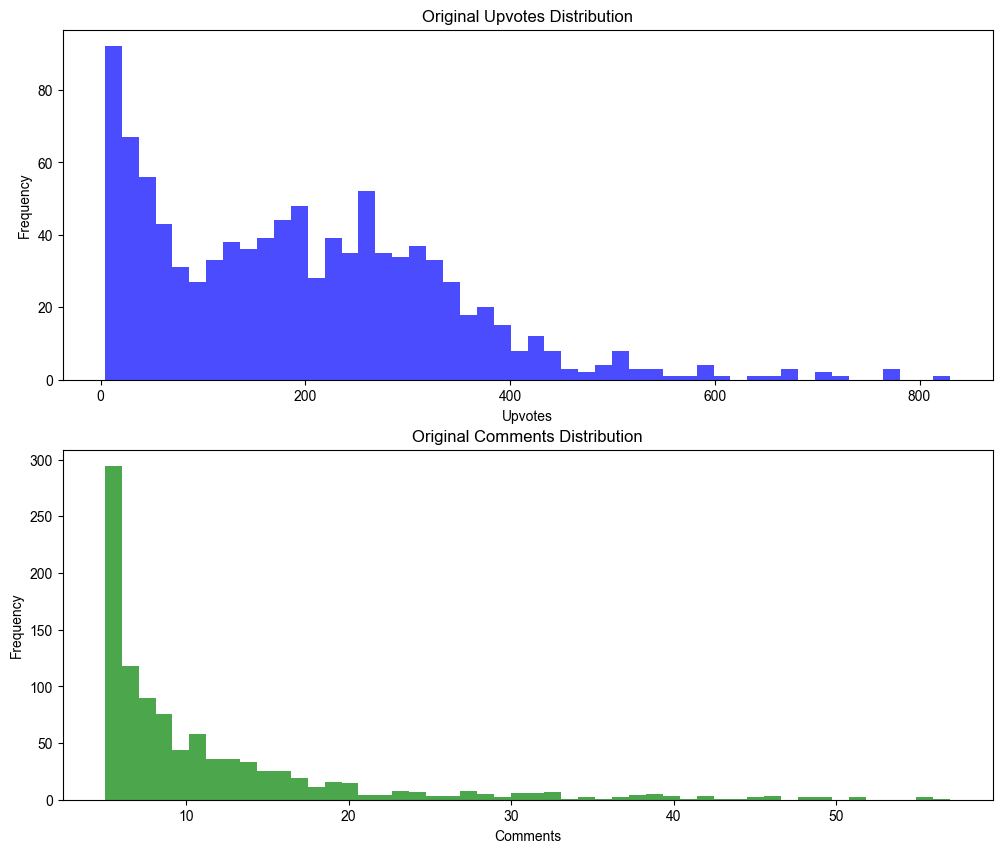

In [137]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Original data
ax[0].hist(df['upvotes'], bins=50, color='blue', alpha=0.7)
ax[0].set_title('Original Upvotes Distribution')
ax[0].set_xlabel('Upvotes')
ax[0].set_ylabel('Frequency')

ax[1].hist(df['comments'], bins=50, color='green', alpha=0.7)
ax[1].set_title('Original Comments Distribution')
ax[1].set_xlabel('Comments')
ax[1].set_ylabel('Frequency')

## Question 1: Does memorability correlate with engagement and sentiments?
### upvotes/# comments ~ memorability score

In [138]:
spearman_comments = scipy.stats.spearmanr(df['memorability_score'], df['comments'])
spearman_upvotes = scipy.stats.spearmanr(df['memorability_score'], df['upvotes'])

print('Memorability ~ Comments:',
      '\n', f'Spearman rho: {spearman_comments[0].round(3)}',
      '\n', f'p value: {spearman_comments[1].round(5)}')

print('Memorability ~ upvotes:',
      '\n', f'Spearman rho: {spearman_upvotes[0].round(3)}',
      '\n', f'p value: {spearman_upvotes[1].round(5)}')

Memorability ~ Comments: 
 Spearman rho: 0.203 
 p value: 0.0
Memorability ~ upvotes: 
 Spearman rho: -0.004 
 p value: 0.90241


### Sentiment Analysis

In [139]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to parse the JSON strings
def parse_json(json_str):
    try:
        return ast.literal_eval(json_str)
    except ValueError as e:
        print(f"Error parsing JSON: {e}")

# Apply the function to each entry in the 'top_comments' column
df.loc[:, 'top_comments'] = df['top_comments'].apply(parse_json)

In [140]:
# interates over each comment in top_comments list for given row
# use analyzer to compute score for comment_body text of each comment
# collects these scores in a list, which is then assigned to a new column in the DataFrame.
df['sentiment_scores'] = df['top_comments'].apply(
    lambda comments: [sia.polarity_scores(comment['comment_body'])['compound'] for comment in comments if 'comment_body' in comment]
)
df.loc[:,'average_sentiment'] = df['sentiment_scores'].apply(lambda scores: sum(scores) / len(scores) if scores else 0)

## Question 2: How does semantic richness or low-level visual sensory information contribute to memorability & reaction?

### memorability / sentiments / engagements ~ early + middle + late CNN layers

#### Data

In [141]:
layers = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/meanDis_image.csv')
layers = layers.drop(outlier_indices).reset_index(drop=True)

In [142]:
layers.rename(columns={
    'Res_11': 'Stage_1',
    'Res_36': 'Stage_2',
    'Res_73': 'Stage_3_Early',
    'Res_109': 'Stage_3_Middle',
    'Res_145': 'Stage_3_Late',
    'Res_155': 'Stage_4'
}, inplace=True)

In [143]:
# Data Preparation
X = layers
y = df['memorability_score'].reset_index(drop=True)

### Levels of CNN correlation with memorability scores

#### GLM

In [144]:
# Data Preparation
X_g = sm.add_constant(layers)

glm_model = sm.GLM(y, X_g, family=sm.families.Gaussian()).fit()
print(glm_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:     memorability_score   No. Observations:                  997
Model:                            GLM   Df Residuals:                      990
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                       0.0073594
Method:                          IRLS   Log-Likelihood:                 1037.3
Date:                Fri, 18 Jul 2025   Deviance:                       7.2858
Time:                        18:56:31   Pearson chi2:                     7.29
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7320
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5109      0.039    -13.

In [146]:
from scipy.stats import norm

# Compute Wald statistic
b_4 = 1.5462
se_4 = 0.048
b_1 = 0.3346
se_1 = 0.128
delta_b = b_4 - b_1
var_delta_b = se_4**2 + se_1**2
W = delta_b / np.sqrt(var_delta_b)

# Calculate p-value (two-tailed)
p_value = 2 * (1 - norm.cdf(abs(W)))

print("Wald Statistic (W):", W)
print("Two-tailed p-value:", p_value)


Wald Statistic (W): 8.862940871426987
Two-tailed p-value: 0.0


#### residuals 

In [147]:
layersR = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/meanDis_image_res.csv')
layersR = layersR.drop(outlier_indices).reset_index(drop=True)
# Data Preparation
X_R = layersR
X_gr = sm.add_constant(layersR)

layersR.rename(columns={
    'Res_11': 'Stage_1',
    'Res_36': 'Stage_2',
    'Res_73': 'Stage_3_Early',
    'Res_109': 'Stage_3_Middle',
    'Res_145': 'Stage_3_Late',
    'Res_155': 'Stage_4'
}, inplace=True)

In [ ]:

memorability = y  # Extract Memorability column as Series
X_gr.columns = X_g.columns

residuals = pd.DataFrame(index=X_g.index, columns=X_g.columns)  # Create a residuals DataFrame
for col in X_g.columns:
    reg = sm.OLS(X_g[col], sm.add_constant(X_gr[[col]])).fit()  # ResNet as predictor, ResMem as target
    predicted = reg.predict(sm.add_constant(X_gr[[col]]))
    residuals[col] = X_g[col] - predicted  # Compute residuals

residuals = residuals.drop(columns="const", errors="ignore") #because the OLS has already mean center the residual matrix

In [ ]:

def fit_gaussian(X, y):
    # Add intercept
    # X = sm.add_constant(X)
    model = sm.GLM(y, X, family=sm.families.Gaussian())
    result = model.fit()  # Use robust standard errors
    return result
# Fit Gaussian Regression Models
# Using ResMem residuals
memorability_centered = memorability - memorability.mean()
gaussian_residuals = fit_gaussian(residuals, memorability_centered)

# Using original ResMem features
gaussian_resmem = fit_gaussian(X_g, memorability_centered)

# Using ResNet features
gaussian_resnet = fit_gaussian(X_gr, memorability_centered)

# Print Summary of Results
print("Gaussian Model (ResMem residuals):")
print(gaussian_residuals.summary())
print("\nGaussian Model (ResMem original):")
print(gaussian_resmem.summary())
print("\nGaussian Model (ResNet):")
print(gaussian_resnet.summary())

Gaussian Model (ResMem residuals):
                 Generalized Linear Model Regression Results                  
Dep. Variable:     memorability_score   No. Observations:                  997
Model:                            GLM   Df Residuals:                      991
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                        0.011333
Method:                          IRLS   Log-Likelihood:                 821.64
Date:                Fri, 18 Jul 2025   Deviance:                       11.231
Time:                        18:56:31   Pearson chi2:                     11.2
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3972
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Stage_1  

/var/folders/l4/l90dznp92ns0myv_j37sn7fm0000gn/T/ipykernel_65098/846355223.py:36: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.2)


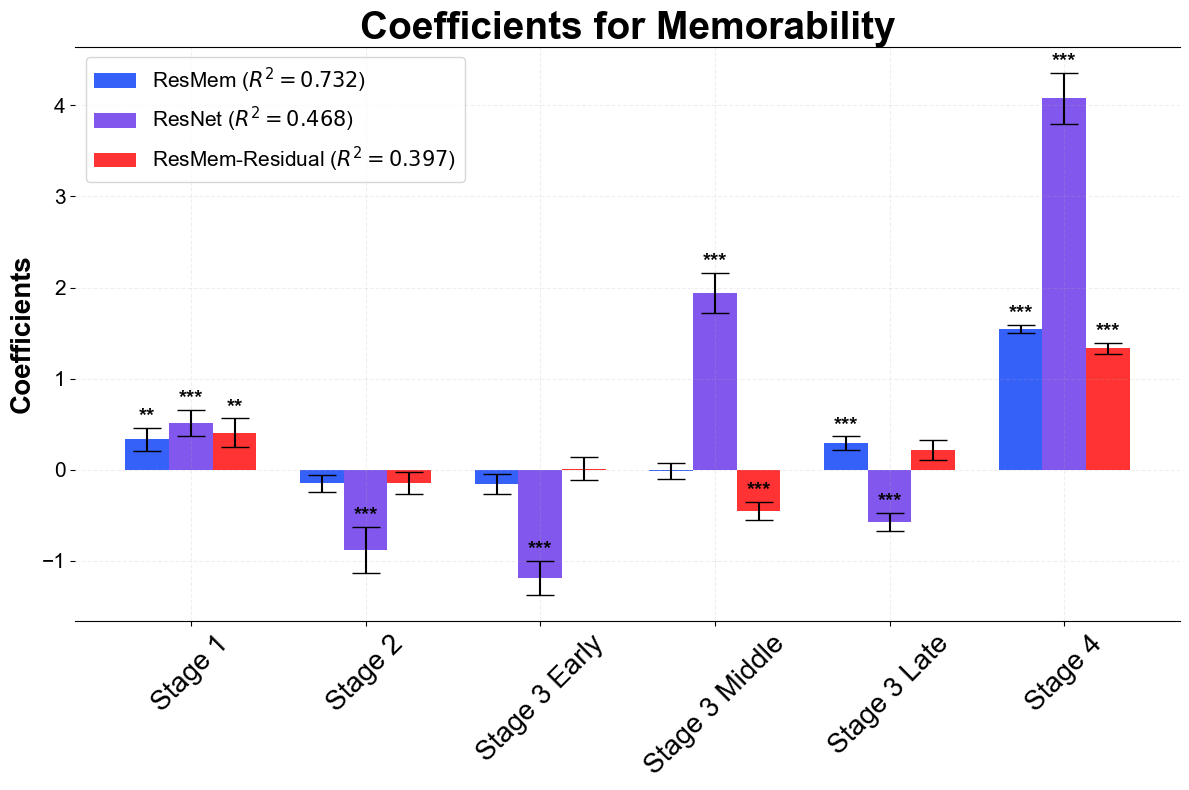

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['font.family']    = 'serif'
mpl.rcParams['font.serif']     = ['Arial']
# Data
stages = ["Stage 1", "Stage 2", "Stage 3 Early", "Stage 3 Middle", "Stage 3 Late", "Stage 4"]
coef = [0.3346, -0.1486, -0.1555, -0.012, 0.2918, 1.5462]
std_err = [0.128, 0.094, 0.107, 0.088, 0.075, 0.048]

stages_r = ["Stage 1", "Stage 2", "Stage 3 Early", "Stage 3 Middle", "Stage 3 Late", "Stage 4"]
coef_r = [0.5143, -0.8761, -1.186, 1.9384, -0.5725, 4.0757]
std_err_r = [0.147, 0.251, 0.184, 0.219, 0.102, 0.281]

stages_resid = ["Stage 1", "Stage 2", "Stage 3 Early", "Stage 3 Middle", "Stage 3 Late", "Stage 4"]
coef_resid = [0.408,-0.142,0.0097,-0.453,0.218,1.333]
std_err_resid = [0.156,0.120,0.126,0.101,0.112,0.064]

x_values = np.arange(len(stages))

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.25  # Bar width (reduced to prevent overlap)

# Plot bars for stages
bars1 = ax.bar(x_values - width, coef, color='#0339f8', yerr=std_err, capsize=10, alpha=0.8, width=width, label='ResMem ($R^2 = 0.732$)')
bars2 = ax.bar(x_values, coef_r, color="#632DE9", yerr=std_err_r, capsize=10, alpha=0.8, width=width, label='ResNet ($R^2 = 0.468$)')
bars3 = ax.bar(x_values + width, coef_resid, color="red", yerr=std_err_resid, capsize=10, alpha=0.8, width=width, label='ResMem-Residual ($R^2 = 0.397$)')

# Axes and labels
ax.set_xticks(x_values)
ax.set_xticklabels(stages, rotation=45, fontsize=20)
plt.yticks(fontsize=15)
ax.set_ylabel('Coefficients', fontsize=20, fontweight='bold')
ax.set_title('Coefficients for Memorability', fontsize=28, fontweight='bold')
ax.grid(False, linestyle='--', alpha=0.2)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add significance markers for 'stages'
significance = [0.009, 1, 1, 1, 0, 0]
significance_r = [0, 0, 0, 0, 0, 0]
significance_resid = [0.009, 1, 1, 0, 0.051, 0]

for i, bar in enumerate(bars1):
    if significance[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Add significance markers for 'stages_r'
for i, bar in enumerate(bars2):
    if significance_r[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_r[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_r[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Add significance markers for 'stages_resid'
for i, bar in enumerate(bars3):
    if significance_resid[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_resid[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_resid[i] <= 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Legend
ax.legend(fontsize=15, loc='upper left')

# Tight layout
plt.tight_layout()
plt.show()


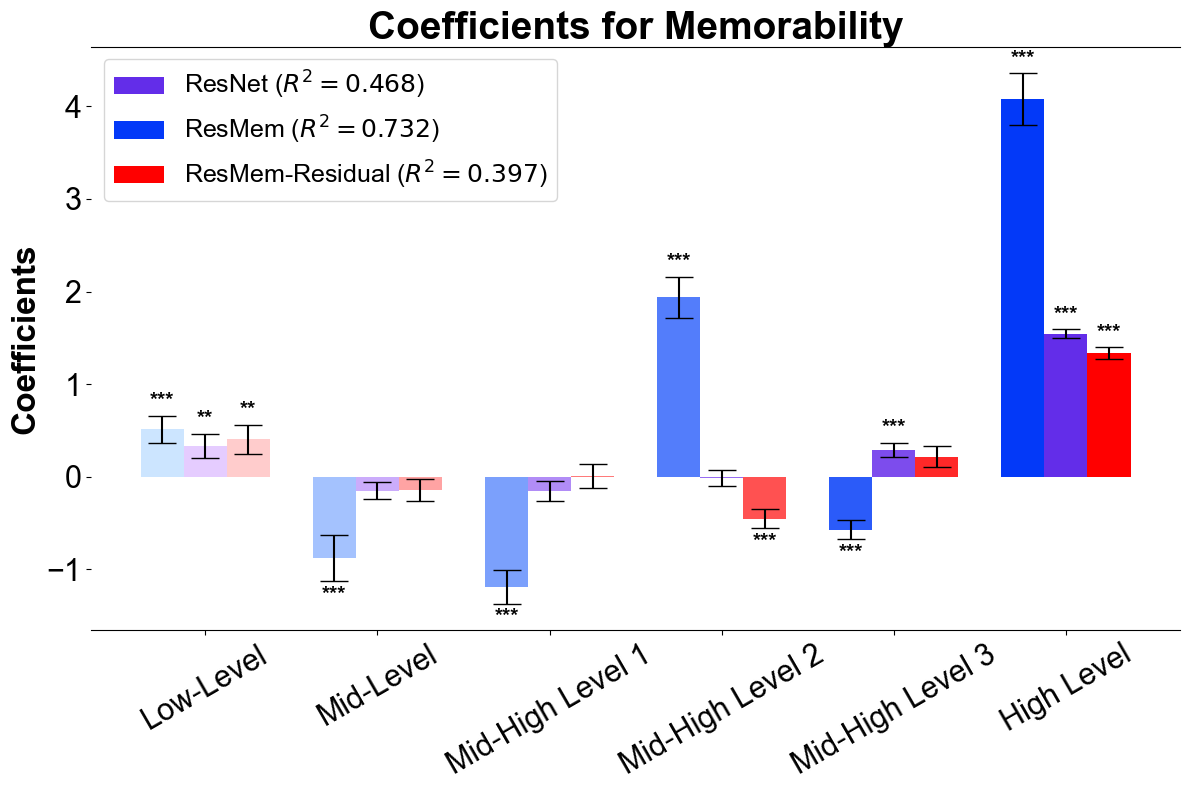

In [160]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

# Data
stages = ["Low-Level", "Mid-Level", "Mid-High Level 1", "Mid-High Level 2", "Mid-High Level 3", "High Level"]
coef = [0.3346, -0.1486, -0.1555, -0.012, 0.2918, 1.5462]
std_err = [0.128, 0.094, 0.107, 0.088, 0.075, 0.048]

coef_r = [0.5143, -0.8761, -1.186, 1.9384, -0.5725, 4.0757]
std_err_r = [0.147, 0.251, 0.184, 0.219, 0.102, 0.281]

coef_resid = [0.408,-0.142,0.0097,-0.453,0.218,1.333]
std_err_resid = [0.156,0.120,0.126,0.101,0.112,0.064]

significance = [0.009, 1, 1, 1, 0, 0]
significance_r = [0, 0, 0, 0, 0, 0]
significance_resid = [0.009, 1, 1, 0, 0.051, 0]

x_values = np.arange(len(stages))
width = 0.25

# Define stronger color gradients
n_stages = len(stages)

# ResMem (Blue)
blue_cmap = LinearSegmentedColormap.from_list(
    "blue_grad", ["#CCE5FF", "#0339f8"], N=300
)
blue_colors = blue_cmap(np.linspace(0, 1, n_stages))

# ResNet (Purple)
purple_cmap = LinearSegmentedColormap.from_list(
    "purple_grad", ["#E5CCFF", "#632DE9"], N=300
)
purple_colors = purple_cmap(np.linspace(0, 1, n_stages))

# ResMem-residual (Red)
red_cmap = LinearSegmentedColormap.from_list(
    "red_grad", ["#FFCCCC", "#FF0000"], N=300
)
red_colors = red_cmap(np.linspace(0, 1, n_stages))

fig, ax = plt.subplots(figsize=(12, 8))

bars1, bars2, bars3 = [], [], []

for i, stage in enumerate(stages):
    bars1.append(
        ax.bar(
            x_values[i] ,
            coef[i],
            width,
            color=purple_colors[i],
            yerr=std_err[i],
            capsize=10,
            edgecolor='none',
            linewidth=0
            
        )
    )
    bars2.append(
        ax.bar(
            x_values[i] - width,
            coef_r[i],
            width,
            color=blue_colors[i],
            yerr=std_err_r[i],
            capsize=10,
            edgecolor='none',
            linewidth=0
        )
    )
    bars3.append(
        ax.bar(
            x_values[i] + width,
            coef_resid[i],
            width,
            color=red_colors[i],
            yerr=std_err_resid[i],
            capsize=10,
            edgecolor='none',
            linewidth=0,
        )
    )

# Convert bar containers to bars
bars1 = [b[0] for b in bars1]
bars2 = [b[0] for b in bars2]
bars3 = [b[0] for b in bars3]

# Add significance markers
def add_sig_markers(bars, sig, std_err_list):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if sig[i] < 0.001:
            txt = '***'
        elif sig[i] < 0.01:
            txt = '**'
        elif sig[i] < 0.05:
            txt = '*'
        else:
            continue
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + np.sign(height)*(std_err_list[i] + 0.05),
            txt,
            ha='center',
            va='bottom' if height >= 0 else 'top',
            color='black',
            fontsize=15,
            fontweight='bold'
        )

add_sig_markers(bars1, significance, std_err)
add_sig_markers(bars2, significance_r, std_err_r)
add_sig_markers(bars3, significance_resid, std_err_resid)

# Axes and labels
ax.set_xticks(x_values)
ax.set_xticklabels(stages, rotation=30, fontsize=22)
plt.yticks(fontsize=22)
ax.set_ylabel('Coefficients', fontsize=24, fontweight='bold')
ax.set_title('Coefficients for Memorability', fontsize=28, fontweight='bold')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create custom legend patches showing pure colors
legend_handles = [
    Patch(facecolor="#632DE9", edgecolor='none', label='ResNet ($R^2 = 0.468$)'),
    Patch(facecolor="#0339f8", edgecolor='none', label='ResMem ($R^2 = 0.732$)'),
    Patch(facecolor="#FF0000", edgecolor='none', label='ResMem-Residual ($R^2 = 0.397$)')
]

ax.legend(handles=legend_handles, fontsize=18, loc='upper left')

plt.tight_layout()
plt.show()


In [152]:
# Predicted values from the model
predicted_y = glm_model.fittedvalues

# Sum of Squares Total (SST)
SST = np.sum((y - np.mean(y))**2)

# Sum of Squares Residual (SSR)
SSR = np.sum((y - predicted_y)**2)

# Pseudo R-squared
pseudo_r_squared = 1 - SSR / SST

print(f'Pseudo R-squared: {pseudo_r_squared}')

Pseudo R-squared: 0.5701207199412799


#### VIF

In [153]:
# Create a DataFrame to hold VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_gr.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_g.values, i) for i in range(X_g.shape[1])]

print(vif_data)

          Feature         VIF
0           const  206.627651
1         Stage_1    1.384113
2         Stage_2    1.648951
3   Stage_3_Early    2.902604
4  Stage_3_Middle    2.496062
5    Stage_3_Late    1.115158
6         Stage_4    1.130493


### How neural layer feature contributes to engagement?

#### Upvotes

In [154]:
import statsmodels.api as sm
X_2 = sm.add_constant(layers)
y_2 = df['upvotes'].reset_index(drop=True)

# Using Negative Binomial regression
nb_model = sm.GLM(y_2, X_2, family=sm.families.NegativeBinomial(alpha = 0.52)).fit(cov_type= 'HC3')
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                upvotes   No. Observations:                  997
Model:                            GLM   Df Residuals:                      990
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6264.0
Date:                Fri, 18 Jul 2025   Deviance:                       1547.8
Time:                        18:56:32   Pearson chi2:                 1.02e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005813
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7786      0.296     16.

#### Comments

In [161]:
import statsmodels.api as sm
X_3 = sm.add_constant(layers)
X_3r = sm.add_constant(layersR)
y_3 = df['comments'].reset_index(drop=True)

# Using Negative Binomial regression
nb_model = sm.GLM(y_3, X_3, family=sm.families.NegativeBinomial(alpha = 0.44)).fit(cov_type= 'HC3')
print(nb_model.summary())

nb_model_r = sm.GLM(y_3, X_3r, family=sm.families.NegativeBinomial(alpha = 0.44)).fit(cov_type= 'HC3')
print(nb_model_r.summary())

residuals['const'] = 1 #centering in NB introduce negative values, violates assumption. Thus has to include an intercept
nb_model_resid = sm.GLM(y_3, residuals, family=sm.families.NegativeBinomial(alpha = 0.44)).fit(cov_type= 'HC3')
print(nb_model_resid.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:               comments   No. Observations:                  997
Model:                            GLM   Df Residuals:                      990
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3250.9
Date:                Fri, 18 Jul 2025   Deviance:                       669.51
Time:                        19:10:09   Pearson chi2:                     996.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02755
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0778      0.318      3.

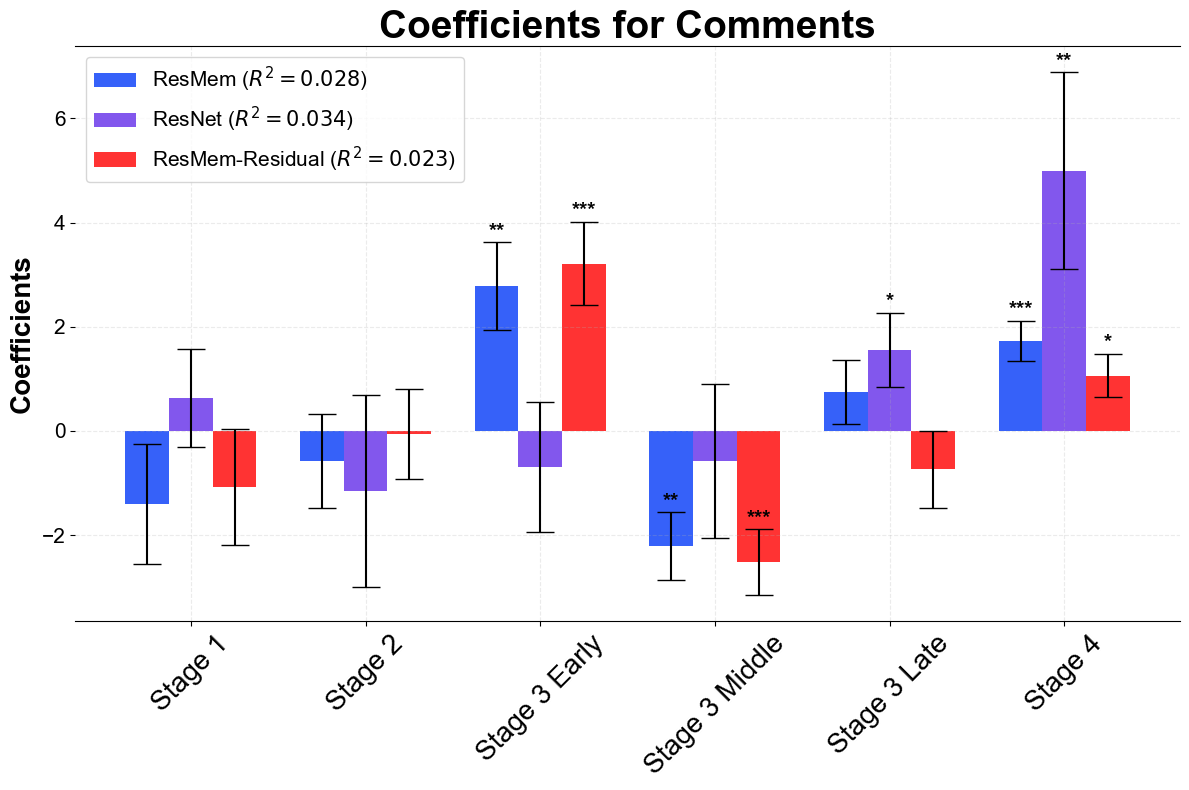

In [162]:
import matplotlib.pyplot as plt
import numpy as np

# Data
stages = ["Stage 1", "Stage 2", "Stage 3 Early", "Stage 3 Middle", "Stage 3 Late", "Stage 4"]
coef = [-1.398, -0.579, 2.783, -2.2131, 0.7538, 1.7336]
std_err = [1.152, 0.904, 0.846, 0.651, 0.612, 0.385]

coef_r = [0.634, -1.1516, -0.6923, -0.5816, 1.5557, 4.9966]
std_err_r = [0.948, 1.838, 1.254, 1.476, 0.714, 1.888]

coef_resid = [-1.077,-0.0559,3.2131,-2.5154,-0.7412,1.0624]
std_err_resid = [1.107,0.861,0.802,0.629,0.737,0.416]

x_values = np.arange(len(stages))

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.25  # Bar width (reduced to prevent overlap)

# Plot bars for stages
bars1 = ax.bar(x_values - width, coef, color='#0339f8', yerr=std_err, capsize=10, alpha=0.8, width=width, label='ResMem ($R^2 = 0.028$)')
bars2 = ax.bar(x_values, coef_r, color="#632DE9", yerr=std_err_r, capsize=10, alpha=0.8, width=width, label='ResNet ($R^2 = 0.034$)')
bars3 = ax.bar(x_values + width, coef_resid, color="red", yerr=std_err_resid, capsize=10, alpha=0.8, width=width, label='ResMem-Residual ($R^2 = 0.023$)')

# Axes and labels
ax.set_xticks(x_values)
ax.set_xticklabels(stages, rotation=45, fontsize=20)
plt.yticks(fontsize=15)
ax.set_ylabel('Coefficients', fontsize=20, fontweight='bold')
ax.set_title('Coefficients for Comments', fontsize=28, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add significance markers for 'stages'
significance = [1,1,0.001,0.001,1,0]
significance_r = [1,1,1,1,0.029,0.008]
significance_resid = [1,1,0,0,1,0.011]

for i, bar in enumerate(bars1):
    if significance[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Add significance markers for 'stages_r'
for i, bar in enumerate(bars2):
    if significance_r[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_r[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_r[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Add significance markers for 'stages_resid'
for i, bar in enumerate(bars3):
    if significance_resid[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_resid[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_resid[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Legend
ax.legend(fontsize=15, loc='upper left')

# Tight layout
plt.tight_layout()
plt.show()


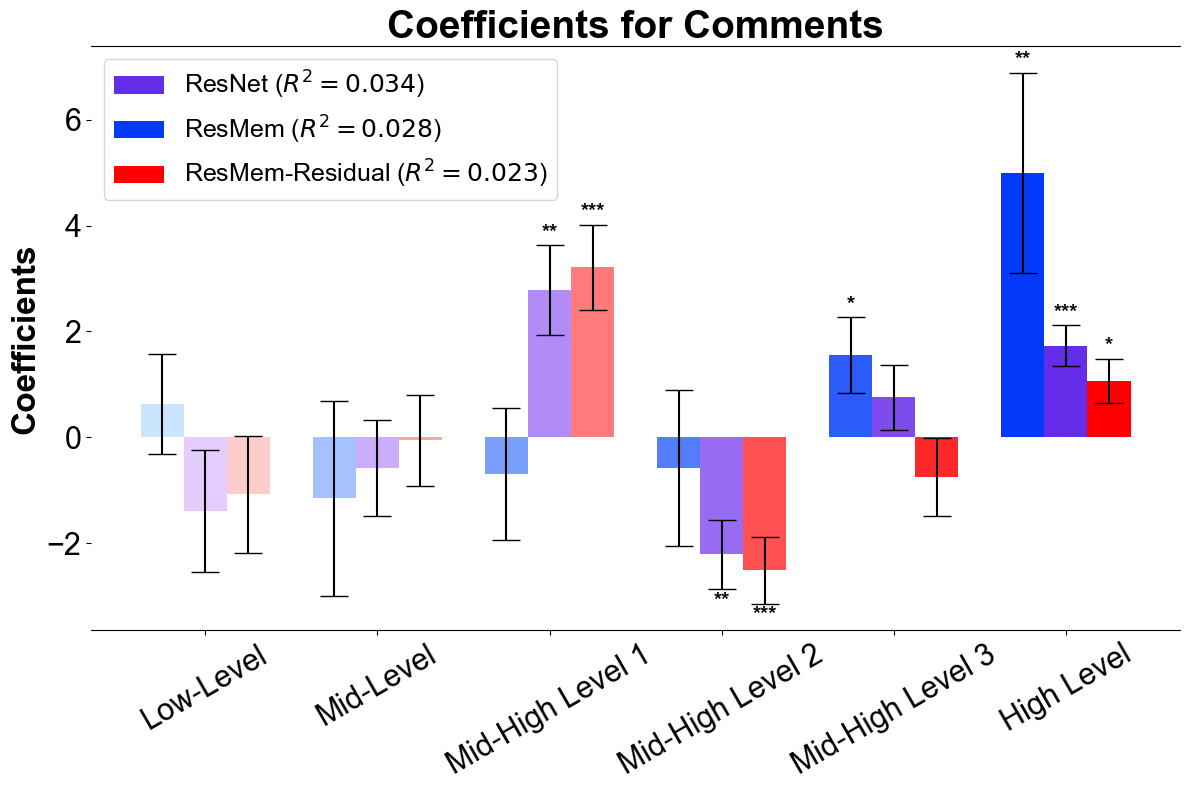

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# Data
stages = ["Low-Level", "Mid-Level", "Mid-High Level 1", "Mid-High Level 2", "Mid-High Level 3", "High Level"]
coef = [-1.398, -0.579, 2.783, -2.2131, 0.7538, 1.7336]
std_err = [1.152, 0.904, 0.846, 0.651, 0.612, 0.385]

coef_r = [0.634, -1.1516, -0.6923, -0.5816, 1.5557, 4.9966]
std_err_r = [0.948, 1.838, 1.254, 1.476, 0.714, 1.888]

coef_resid = [-1.077,-0.0559,3.2131,-2.5154,-0.7412,1.0624]
std_err_resid = [1.107,0.861,0.802,0.629,0.737,0.416]

# Add significance markers for 'stages'
significance = [1,1,0.001,0.001,1,0]
significance_r = [1,1,1,1,0.029,0.008]
significance_resid = [1,1,0,0,1,0.011]

x_values = np.arange(len(stages))
width = 0.25

# Define stronger color gradients
n_stages = len(stages)

# ResMem (Blue)
blue_cmap = LinearSegmentedColormap.from_list(
    "blue_grad", ["#CCE5FF", "#0339f8"], N=300
)
blue_colors = blue_cmap(np.linspace(0, 1, n_stages))

# ResNet (Purple)
purple_cmap = LinearSegmentedColormap.from_list(
    "purple_grad", ["#E5CCFF", "#632DE9"], N=300
)
purple_colors = purple_cmap(np.linspace(0, 1, n_stages))

# ResMem-residual (Red)
red_cmap = LinearSegmentedColormap.from_list(
    "red_grad", ["#FFCCCC", "#FF0000"], N=300
)
red_colors = red_cmap(np.linspace(0, 1, n_stages))

fig, ax = plt.subplots(figsize=(12, 8))

bars1, bars2, bars3 = [], [], []

for i, stage in enumerate(stages):
    bars1.append(
        ax.bar(
            x_values[i] ,
            coef[i],
            width,
            color=purple_colors[i],
            yerr=std_err[i],
            capsize=10,
            edgecolor='none',
            linewidth=0
            
        )
    )
    bars2.append(
        ax.bar(
            x_values[i] - width,
            coef_r[i],
            width,
            color=blue_colors[i],
            yerr=std_err_r[i],
            capsize=10,
            edgecolor='none',
            linewidth=0
        )
    )
    bars3.append(
        ax.bar(
            x_values[i] + width,
            coef_resid[i],
            width,
            color=red_colors[i],
            yerr=std_err_resid[i],
            capsize=10,
            edgecolor='none',
            linewidth=0,
        )
    )

# Convert bar containers to bars
bars1 = [b[0] for b in bars1]
bars2 = [b[0] for b in bars2]
bars3 = [b[0] for b in bars3]

# Add significance markers
def add_sig_markers(bars, sig, std_err_list):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if sig[i] < 0.001:
            txt = '***'
        elif sig[i] < 0.01:
            txt = '**'
        elif sig[i] < 0.05:
            txt = '*'
        else:
            continue
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + np.sign(height)*(std_err_list[i] + 0.05),
            txt,
            ha='center',
            va='bottom' if height >= 0 else 'top',
            color='black',
            fontsize=15,
            fontweight='bold'
        )

add_sig_markers(bars1, significance, std_err)
add_sig_markers(bars2, significance_r, std_err_r)
add_sig_markers(bars3, significance_resid, std_err_resid)

# Axes and labels
ax.set_xticks(x_values)
ax.set_xticklabels(stages, rotation=30, fontsize=22)
plt.yticks(fontsize=22)
ax.set_ylabel('Coefficients', fontsize=24, fontweight='bold')
ax.set_title('Coefficients for Comments', fontsize=28, fontweight='bold')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create custom legend patches showing pure colors
legend_handles = [
    Patch(facecolor="#632DE9", edgecolor='none', label='ResNet ($R^2 = 0.034$)'),
    Patch(facecolor="#0339f8", edgecolor='none', label='ResMem ($R^2 = 0.028$)'),
    Patch(facecolor="#FF0000", edgecolor='none', label='ResMem-Residual ($R^2 = 0.023$)')
]

ax.legend(handles=legend_handles, fontsize=18, loc='upper left')

plt.tight_layout()
plt.show()



### How does semantic richness relates to sentiment?

In [164]:
# Data Preparation
import statsmodels.api as sm
X_4 = sm.add_constant(layers)
X_4r = sm.add_constant(layersR)
y_4 = df['average_sentiment'].reset_index(drop=True)

model = sm.GLM(y_4, X_4, family=sm.families.Gaussian()).fit(cov_type='HC3')
print(model.summary())

model_r = sm.GLM(y_4, X_4r, family=sm.families.Gaussian()).fit(cov_type='HC3')
print(model_r.summary())

model_resid = sm.GLM(y_4, residuals, family=sm.families.Gaussian()).fit(cov_type='HC3')
print(model_resid.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      average_sentiment   No. Observations:                  997
Model:                            GLM   Df Residuals:                      990
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                        0.048091
Method:                          IRLS   Log-Likelihood:                 101.60
Date:                Fri, 18 Jul 2025   Deviance:                       47.611
Time:                        19:14:08   Pearson chi2:                     47.6
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03896
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6835      0.100      6.

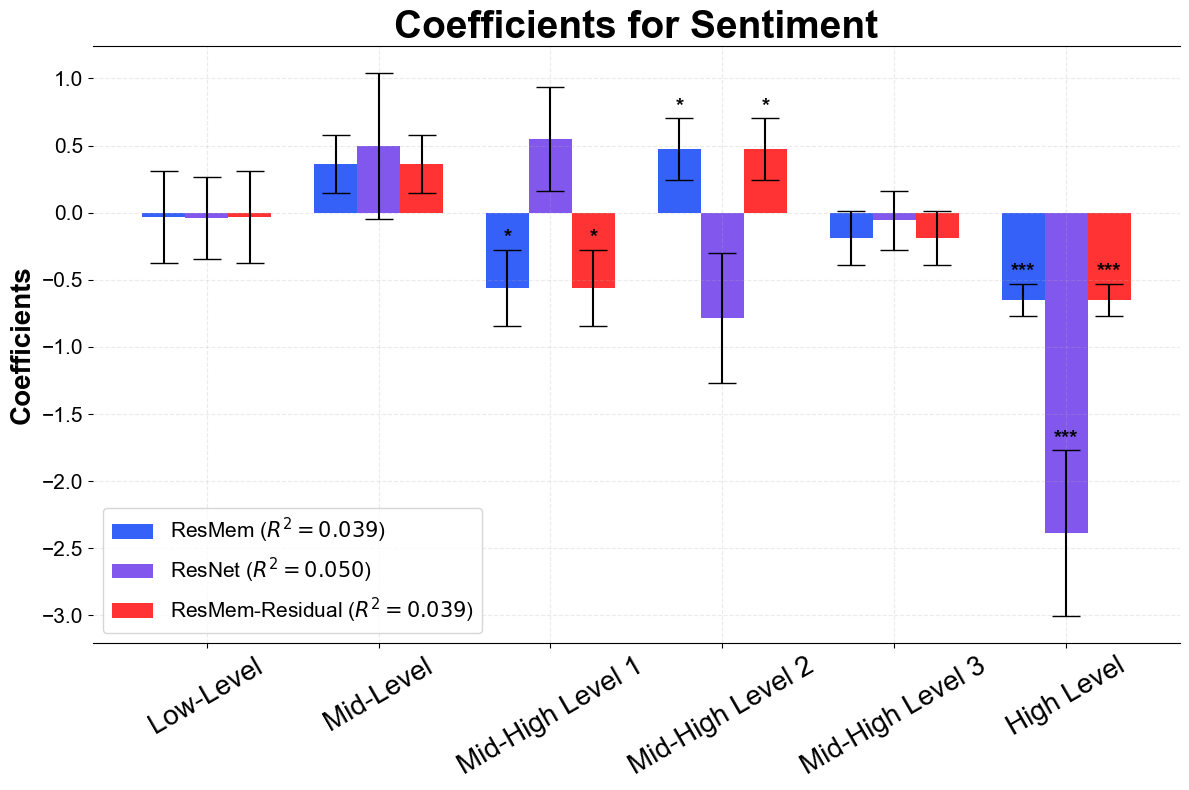

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Data
stages = ["Low-Level", "Mid-Level", "Mid-High Level 1", "Mid-High Level 2", "Mid-High Level 3", "High Level"]
coef = [-0.03,0.3628,-0.558,0.476,-0.1902,-0.6475]
std_err = [0.344,0.215,0.283,0.229,0.202,0.120]

coef_r =[-0.0410,0.4964,0.5465,-0.7838,-0.0577,-2.3866]
std_err_r = [0.307,0.541,0.387,0.482,0.222,0.620]

coef_resid = [-0.03,0.363,-0.558,0.476,-0.1902,-0.6475]
std_err_resid = [0.344,0.215,0.283,0.229,0.202,0.120]

x_values = np.arange(len(stages))

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.25  # Bar width (reduced to prevent overlap)

# Plot bars for stages
bars1 = ax.bar(x_values - width, coef, color='#0339f8', yerr=std_err, capsize=10, alpha=0.8, width=width, label='ResMem ($R^2 = 0.039$)')
bars2 = ax.bar(x_values, coef_r, color="#632DE9", yerr=std_err_r, capsize=10, alpha=0.8, width=width, label='ResNet ($R^2 = 0.050$)')
bars3 = ax.bar(x_values + width, coef_resid, color="red", yerr=std_err_resid, capsize=10, alpha=0.8, width=width, label='ResMem-Residual ($R^2 = 0.039$)')

# Axes and labels
ax.set_xticks(x_values)
ax.set_xticklabels(stages, rotation=30, fontsize=20)
plt.yticks(fontsize=15)
ax.set_ylabel('Coefficients', fontsize=20, fontweight='bold')
ax.set_title('Coefficients for Sentiment', fontsize=28, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add significance markers for 'stages'
significance = [1,0.092,0.049,0.037,1,0]
significance_r = [1,1,1,1,1,0.000]
significance_resid = [1,1,0.049,0.037,1,0.000]

for i, bar in enumerate(bars1):
    if significance[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Add significance markers for 'stages_r'
for i, bar in enumerate(bars2):
    if significance_r[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_r[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_r[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_r[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Add significance markers for 'stages_resid'
for i, bar in enumerate(bars3):
    if significance_resid[i] < 0.001:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '***',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_resid[i] < 0.01:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '**',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')
    elif significance_resid[i] < 0.05:
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + std_err_resid[i] + 0.01, '*',
                ha='center', va='bottom', color='black', fontsize=15, fontweight='bold')

# Legend
ax.legend(fontsize=15, loc='lower left')

# Tight layout
plt.tight_layout()
plt.show()


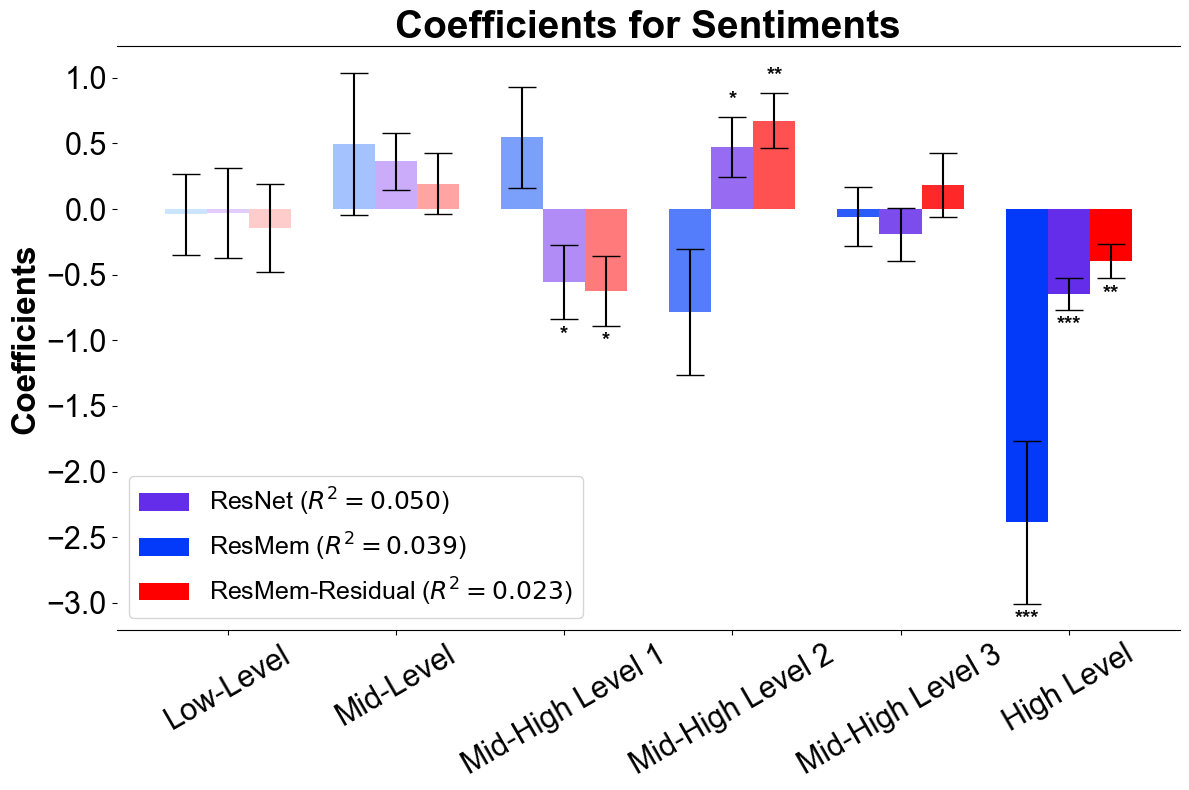

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Data
stages = ["Low-Level", "Mid-Level", "Mid-High Level 1", "Mid-High Level 2", "Mid-High Level 3", "High Level"]
coef = [-0.03,0.3628,-0.558,0.476,-0.1902,-0.6475]
std_err = [0.344,0.215,0.283,0.229,0.202,0.120]

coef_r =[-0.0410,0.4964,0.5465,-0.7838,-0.0577,-2.3866]
std_err_r = [0.307,0.541,0.387,0.482,0.222,0.620]

coef_resid = [-0.1431,0.194,-0.6247,0.6745,0.1809,-0.3948]
std_err_resid = [0.336,0.23,0.264,0.212,0.244,0.132]

# Add significance markers for 'stages'
significance = [1,0.092,0.049,0.037,1,0]
significance_r = [1,1,1,1,1,0.000]
significance_resid = [1,1,0.018,0.001,1,0.003]

x_values = np.arange(len(stages))
width = 0.25

# Define stronger color gradients
n_stages = len(stages)

# ResMem (Blue)
blue_cmap = LinearSegmentedColormap.from_list(
    "blue_grad", ["#CCE5FF", "#0339f8"], N=300
)
blue_colors = blue_cmap(np.linspace(0, 1, n_stages))

# ResNet (Purple)
purple_cmap = LinearSegmentedColormap.from_list(
    "purple_grad", ["#E5CCFF", "#632DE9"], N=300
)
purple_colors = purple_cmap(np.linspace(0, 1, n_stages))

# ResMem-residual (Red)
red_cmap = LinearSegmentedColormap.from_list(
    "red_grad", ["#FFCCCC", "#FF0000"], N=300
)
red_colors = red_cmap(np.linspace(0, 1, n_stages))

fig, ax = plt.subplots(figsize=(12, 8))

bars1, bars2, bars3 = [], [], []

for i, stage in enumerate(stages):
    bars1.append(
        ax.bar(
            x_values[i] ,
            coef[i],
            width,
            color=purple_colors[i],
            yerr=std_err[i],
            capsize=10,
            edgecolor='none',
            linewidth=0
            
        )
    )
    bars2.append(
        ax.bar(
            x_values[i] - width,
            coef_r[i],
            width,
            color=blue_colors[i],
            yerr=std_err_r[i],
            capsize=10,
            edgecolor='none',
            linewidth=0
        )
    )
    bars3.append(
        ax.bar(
            x_values[i] + width,
            coef_resid[i],
            width,
            color=red_colors[i],
            yerr=std_err_resid[i],
            capsize=10,
            edgecolor='none',
            linewidth=0,
        )
    )

# Convert bar containers to bars
bars1 = [b[0] for b in bars1]
bars2 = [b[0] for b in bars2]
bars3 = [b[0] for b in bars3]

# Add significance markers
def add_sig_markers(bars, sig, std_err_list):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if sig[i] < 0.001:
            txt = '***'
        elif sig[i] < 0.01:
            txt = '**'
        elif sig[i] < 0.05:
            txt = '*'
        else:
            continue
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height + np.sign(height)*(std_err_list[i] + 0.05),
            txt,
            ha='center',
            va='bottom' if height >= 0 else 'top',
            color='black',
            fontsize=15,
            fontweight='bold'
        )

add_sig_markers(bars1, significance, std_err)
add_sig_markers(bars2, significance_r, std_err_r)
add_sig_markers(bars3, significance_resid, std_err_resid)

# Axes and labels
ax.set_xticks(x_values)
ax.set_xticklabels(stages, rotation=30, fontsize=22)
plt.yticks(fontsize=22)
ax.set_ylabel('Coefficients', fontsize=24, fontweight='bold')
ax.set_title('Coefficients for Sentiments', fontsize=28, fontweight='bold')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)


# Create custom legend patches showing pure colors
legend_handles = [
    Patch(facecolor="#632DE9", edgecolor='none', label='ResNet ($R^2 = 0.050$)'),
    Patch(facecolor="#0339f8", edgecolor='none', label='ResMem ($R^2 = 0.039$)'),
    Patch(facecolor="#FF0000", edgecolor='none', label='ResMem-Residual ($R^2 = 0.023$)')
]

ax.legend(handles=legend_handles, fontsize=18, loc='lower left')

plt.tight_layout()
plt.show()



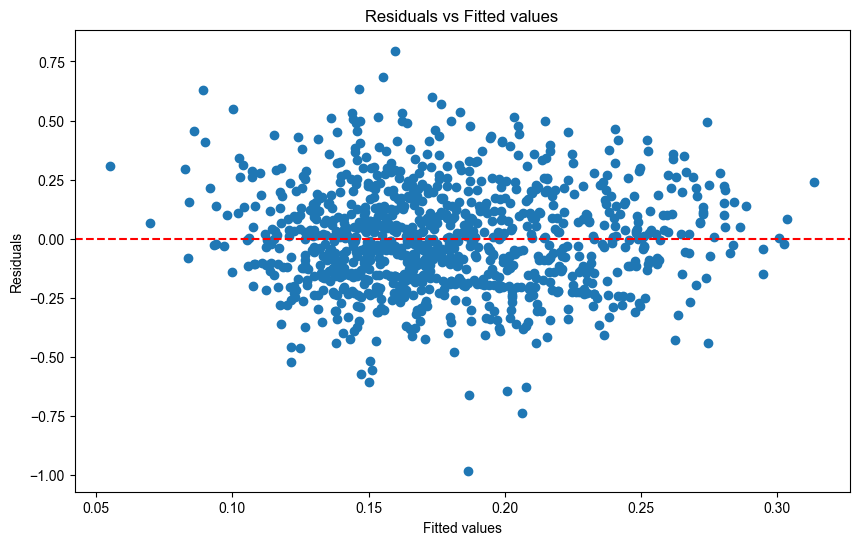

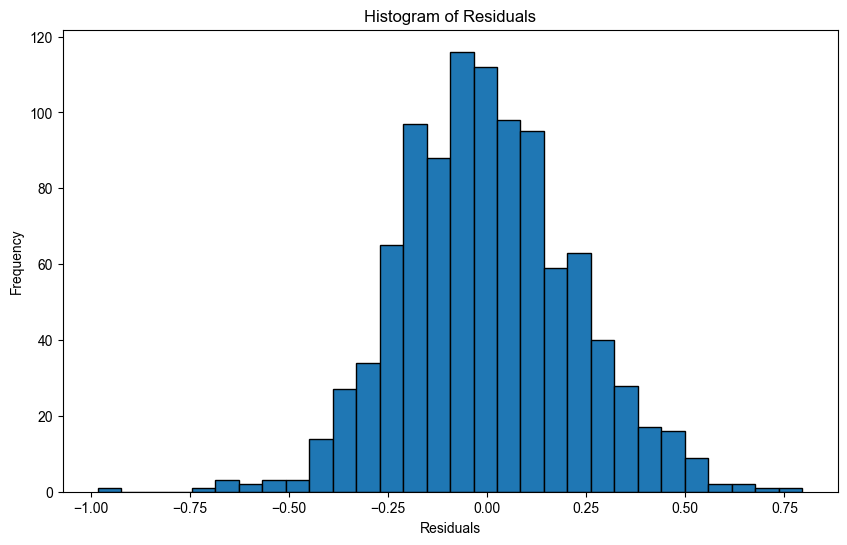

Mean of Residuals: 3.4003781624828267e-15
Variance of Residuals: 0.04775381723913289
Standard Deviation of Residuals: 0.21852646805165934


In [55]:
residuals = model.resid_response

# Create a DataFrame to hold the fitted values and residuals
residuals_df = pd.DataFrame({
    'Fitted': model.fittedvalues,
    'Residuals': residuals
})

# Residuals vs Fitted Plot
plt.figure(figsize=(10, 6))
plt.scatter(residuals_df['Fitted'], residuals_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Print Residual Statistics
print(f"Mean of Residuals: {np.mean(residuals)}")
print(f"Variance of Residuals: {np.var(residuals)}")
print(f"Standard Deviation of Residuals: {np.std(residuals)}")


## Question 3: Semantic Analysis in Comments

#### Toolkits for Semantic Analysis

In [ ]:
import contractions
from collections import Counter, defaultdict
import emoji
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models.phrases import Phrases, Phraser
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models import HdpModel
from gensim import corpora, models, matutils
from gensim.models.ldamodel import LdaModel

#### Tokenization &  Lemmatization 

In [ ]:
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_symbols(text):
    # This pattern will keep only alphabetic characters, apostrophes, and spaces
    symbol_pattern = re.compile(r'[^a-zA-Z\s]')
    return symbol_pattern.sub('', text)

def clean_repetition(text):
    # This regex replaces instances of the same character repeating 3 or more times
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return text

In [ ]:
nlp = spacy.load('en_core_web_sm')
# Define custom stop words

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define additional stop words
custom_stop_words = ['lol', 'shit', 'rightofway', 'bit', 'lot', 'min', 
                     'picknmix', 'pullyu', 'rfixedit', 'picture', 'image', 'photo',
                     'post', 'thank', 'pic']  

# Add custom stop words to the default SpaCy stop words list
for word in custom_stop_words:
    nlp.Defaults.stop_words.add(word)
    nlp.vocab[word].is_stop = True

In [ ]:
comments_dict = {}

# Process each comment
for index, row in df.iterrows():
    # Clean the data thru cleaning functions
    comments = [clean_repetition(remove_emojis(remove_urls(contractions.fix(comment['comment_body'])))) for comment in row['top_comments'] if 'comment_body' in comment]
    comments = [remove_symbols(comment) for comment in comments]
    # Store all the data
    processed_comments = {}
    for i, comment in enumerate(comments):
        doc = nlp(comment)
        # Only include nouns and word.length > 2
        filtered_lemmatized_words = [
            token.lemma_.lower() for token in doc 
            if token.pos_ in ['NOUN'] and len(token.text) > 2 and token.lemma_.lower() and not token.is_stop
        ]
        processed_comments[f'Comment_{i+1}'] = filtered_lemmatized_words

    comments_dict[row['id']] = processed_comments

#### Test to see if semantic richness is related to memorability of the image

In [ ]:
# Initialize a list to hold each row's data
rows_list_words = []

# Process each image ID in the comments dictionary
for image_id, comments in comments_dict.items():
    # Flatten the list of words from all comments for this image
    words = [word for comment_id in comments for word in comments[comment_id]]
    # Count the frequencies of each word
    # Create a dictionary for the current row
    row_data = {
        'Image ID': image_id,
        'Words': words  # This will store the list of tuples
    }
    # Append the row data to the list
    rows_list_words.append(row_data)

# Create a DataFrame from the list of rows
words_df = pd.DataFrame(rows_list_words)
words_df['memorability scores'] = df['memorability_score'].reset_index(drop=True)
words_df

,Image ID,Words,memorability scores
0,1c7hzb1,"[version, spaghetti, feeding, birch, posture, ...",0.844453
1,1c7uef5,"[butterfly, account, stuff, butterfly, thing, ...",0.715792
2,1c6uaa0,"[aircraft, speed, mph, year, speed, mph, cockp...",0.735333
3,1c7ruyn,"[bear, baldness, bear, hair, rumor, fur, inspi...",0.838639
4,1c70p7m,"[surviving, mean, sister]",0.781850
...,...,...,...
992,j6h2ba,[],0.517462
993,j6fa6m,"[time, week, today]",0.455731
994,1cude46,"[wisdom, grace, cow, size, freezer, cow, savin...",0.944620
995,1csmo2g,"[tourist, spot, hiking, trail, video, faith, i...",0.837740


In [ ]:
# Check for empty lists in 'Top 10 Words'
words_df['Blank'] = words_df['Words'].apply(lambda x: len(x) == 0)
# Store IDs of images with empty 'Top 10 Words'
empty_top_words = words_df[words_df['Blank']]['Image ID'].tolist()

print("Image IDs with empty 'Words':", empty_top_words)

words_df = words_df[~words_df['Blank']]

Image IDs with empty 'Words': ['1c6ssnk', '1c7vhvv', '1c7mg8h', '1820e93', '14kxbe4', '11t7g6k', 'wj0z50', '119tfs9', 'qfuhly', '1cb8o8r', '1ccfje9', '1cd6ovf', '1ccex8v', '1b34ezy', 'r1wvac', 'lttl1g', '1cwy9s7', '1cwf34c', '1cv3o94', '1cwj9cu', '1cvxvcc', 'r7a67f', 'qbu67n', 'qb8qxh', 'pokt9t', 'nqpk9w', 'mgf481', 'lqq35z', 'lgziqc', 'kjtfdp', 'jsabl0', 'j6h2ba']


In [ ]:
def create_document(words):
    # Join the list of words into a single string (a document)
    document = ' '.join(words)
    return document

words_df.loc[:,'Document'] = words_df['Words'].apply(create_document)

# Create a list that contains the text of each document
documents_nfrq = words_df['Document'].tolist()

/var/folders/l4/l90dznp92ns0myv_j37sn7fm0000gn/T/ipykernel_53939/305948859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words_df.loc[:,'Document'] = words_df['Words'].apply(create_document)


In [ ]:
# Count the number of words in each entry of the 'Words' column
words_df.loc[:,'Word Count'] = words_df['Words'].apply(lambda x: len(x))

/var/folders/l4/l90dznp92ns0myv_j37sn7fm0000gn/T/ipykernel_53939/564338894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words_df.loc[:,'Word Count'] = words_df['Words'].apply(lambda x: len(x))


In [ ]:
words_df = words_df.reset_index(drop=True)

In [ ]:
spearman_semantics = scipy.stats.spearmanr(words_df['memorability scores'], words_df['Word Count'])
print('Memorability ~ Semantic Richness:',
      '\n', f'Spearman rho: {spearman_semantics[0].round(3)}',
      '\n', f'p value: {spearman_semantics[1].round(5)}')

Memorability ~ Semantic Richness: 
 Spearman rho: 0.061 
 p value: 0.05863


#### WorkCloud 2

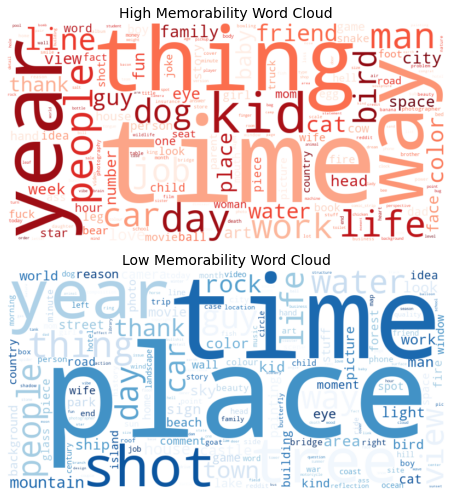

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Calculate the median memorability score
median_memorability = words_df['memorability scores'].median()

# Filter the dataset for high memorability
high_mem_df = words_df[words_df['memorability scores'] > median_memorability]
low_mem_df = words_df[words_df['memorability scores'] <= median_memorability]

# Aggregate all words from the high memorability descriptions
high_mem_words = [word for sublist in high_mem_df['Words'] for word in sublist]
# Aggregate all words from the low memorability descriptions
low_mem_words = [word for sublist in low_mem_df['Words'] for word in sublist]

# Count the frequency of each word in both groups
high_mem_word_freq = pd.Series(high_mem_words).value_counts().to_dict()
low_mem_word_freq = pd.Series(low_mem_words).value_counts().to_dict()

# Create a word cloud for the high memorability group
high_mem_wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', colormap= 'Reds'
).generate_from_frequencies(high_mem_word_freq)

# Create a word cloud for the low memorability group
low_mem_wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', colormap = 'Blues'
).generate_from_frequencies(low_mem_word_freq)

# Display the word clouds
plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)  # 2 row, 1 columns, 1st subplot
plt.imshow(high_mem_wordcloud, interpolation='bilinear')
plt.title('High Memorability Word Cloud', fontsize=14)
plt.axis('off')

plt.subplot(2, 1, 2)  # 1 row, 1 columns, 2nd subplot
plt.imshow(low_mem_wordcloud, interpolation='bilinear')
plt.title('Low Memorability Word Cloud', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
from scipy.stats import ttest_ind, zscore

# Read the CSV files
high_mem_con = pd.read_csv('high_mem_words_with_concreteness_new.csv', index_col=False)
low_mem_con = pd.read_csv('low_mem_words_with_concreteness_new.csv', index_col=False)

# Remove rows where concreteness is equal to 0
high_mem_con = high_mem_con[high_mem_con['concreteness'] != 0]
low_mem_con = low_mem_con[low_mem_con['concreteness'] != 0]

In [ ]:
# Convert word frequency dictionaries to DataFrames
high_mem_freq_df = pd.DataFrame(list(high_mem_word_freq.items()), columns=['word', 'frequency'])
low_mem_freq_df = pd.DataFrame(list(low_mem_word_freq.items()), columns=['word', 'frequency'])

# Calculate standard deviation and mean for frequencies
high_std = high_mem_freq_df['frequency'].std()
low_std = low_mem_freq_df['frequency'].std()
high_mean = high_mem_freq_df['frequency'].mean()
low_mean = low_mem_freq_df['frequency'].mean()

# Define the threshold for high frequency words: mean + 1.5*standard deviation
high_threshold_high_mem = high_mean + 1.5 * high_std
high_threshold_low_mem = low_mean + 1.5 * low_std

# Identify high-frequency words based on the new threshold
high_freq_words_high_mem = high_mem_freq_df[high_mem_freq_df['frequency'] > high_threshold_high_mem]['word'].tolist()
high_freq_words_low_mem = low_mem_freq_df[low_mem_freq_df['frequency'] > high_threshold_low_mem]['word'].tolist()

# Filter the DataFrames based on high-frequency words
high_freq_high_mem_con = high_mem_con[high_mem_con['word'].isin(high_freq_words_high_mem)]
high_freq_low_mem_con = low_mem_con[low_mem_con['word'].isin(high_freq_words_low_mem)]

# Show the average scores for concreteness
high_freq_high_mem_avg = high_freq_high_mem_con['concreteness'].mean()
high_freq_low_mem_avg = high_freq_low_mem_con['concreteness'].mean()
print(f"Average concreteness for high-frequency high memory words: {high_freq_high_mem_avg}")
print(f"Average concreteness for high-frequency low memory words: {high_freq_low_mem_avg}")

# Extract the concreteness scores for the high-frequency words
high_freq_high_mem_scores = high_freq_high_mem_con['concreteness']
high_freq_low_mem_scores = high_freq_low_mem_con['concreteness']


Average concreteness for high-frequency high memory words: 4.010318791946309
Average concreteness for high-frequency low memory words: 4.035818022747157


In [ ]:
import numpy as np
from scipy.stats import ttest_ind, norm

def analyze_groups(data1, data2, confidence=0.95):
    """
    Perform an independent two-sample t-test, calculate Cohen's d, and compute the confidence interval for the difference.

    Parameters:
    data1 (array-like): Data for group 1.
    data2 (array-like): Data for group 2.
    confidence (float): Confidence level for the interval.

    Returns:
    dict: Results containing T-statistic, P-value, Cohen's d, and confidence interval.
    """
    # Calculate t-test
    t_stat, p_value = ttest_ind(data1, data2)
    
    # Calculate means and standard deviations
    mean1, mean2 = np.mean(data1), np.mean(data2)
    std1, std2 = np.std(data1, ddof=1), np.std(data2, ddof=1)
    n1, n2 = len(data1), len(data2)
    
    # Calculate Cohen's d
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    cohens_d = (mean1 - mean2) / pooled_std
    
    # Calculate the standard error and margin of error for the confidence interval
    se = np.sqrt(std1**2 / n1 + std2**2 / n2)
    margin_of_error = norm.ppf((1 + confidence) / 2) * se
    
    # Calculate the confidence interval
    ci_lower = (mean1 - mean2) - margin_of_error
    ci_upper = (mean1 - mean2) + margin_of_error
    
    return {
        "T-statistic": t_stat,
        "P-value": p_value,
        "Cohen's d": cohens_d,
        "Confidence Interval": (ci_lower, ci_upper),
        "std1": std1,
        "std2": std2
    }

results = analyze_groups(high_freq_high_mem_scores, high_freq_low_mem_scores)
print(results)


{'T-statistic': -0.6953070989947406, 'P-value': 0.4869321132044394, "Cohen's d": -0.028784511472041575, 'Confidence Interval': (-0.0974028790928217, 0.046404417491126296), 'std1': 0.8785848856115567, 'std2': 0.893397071646117}


In [ ]:
percentiles = high_mem_freq_df['frequency'].describe(percentiles=[0.25, 0.5, 0.75])

percentiles[['25%', '50%', '75%']]

25%    1.0
50%    1.0
75%    2.0
Name: frequency, dtype: float64

/var/folders/l4/l90dznp92ns0myv_j37sn7fm0000gn/T/ipykernel_53939/1298582839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_freq_high_mem_con['group'] = 'High Memorability'
/var/folders/l4/l90dznp92ns0myv_j37sn7fm0000gn/T/ipykernel_53939/1298582839.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_freq_low_mem_con['group'] = 'Low Memorability'


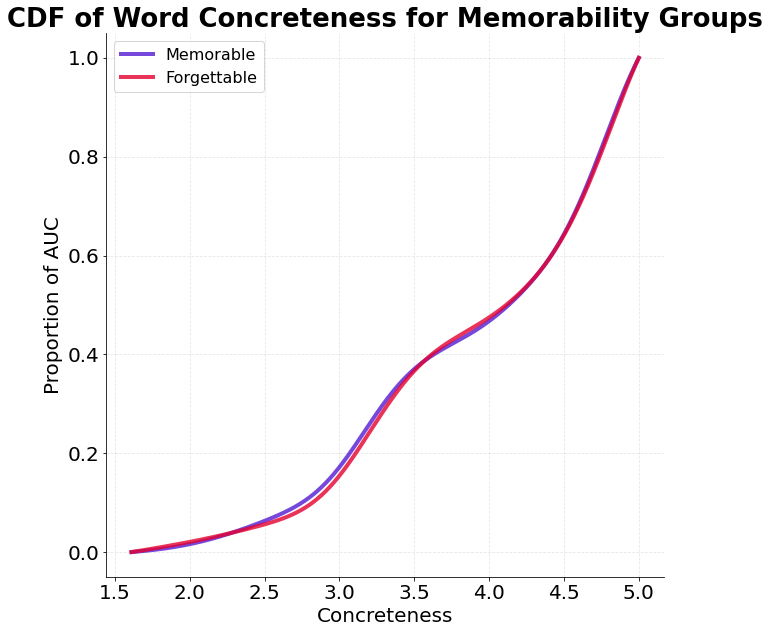

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

high_freq_high_mem_con['group'] = 'High Memorability'
high_freq_low_mem_con['group'] = 'Low Memorability'

con_df = pd.concat([high_freq_high_mem_con, high_freq_low_mem_con])

# Function to calculate KDE-based CDF
def kde_cdf(data, bw_method=0.1):
    kde = gaussian_kde(data, bw_method=bw_method)
    x = np.linspace(data.min(), data.max(), 1000)
    y = np.cumsum(kde(x))
    y /= y[-1]  # Normalize to get CDF
    return x, y

# Calculate CDF for both groups
x_high, y_high = kde_cdf(con_df[con_df['group'] == 'High Memorability']['concreteness'], bw_method=0.25)
x_low, y_low = kde_cdf(con_df[con_df['group'] == 'Low Memorability']['concreteness'], bw_method=0.25)

plt.figure(figsize=(10, 10))

plt.plot(x_high, y_high, linestyle='-', color='#5219d2', alpha=0.8, linewidth=4)
plt.plot(x_low, y_low, linestyle='-', color='#e4002e', alpha=0.8, linewidth=4) 
plt.xlabel('Concreteness', fontsize=20)
plt.ylabel("Proportion of AUC", fontsize=20)
plt.title('CDF of Word Concreteness for Memorability Groups', fontsize=26, fontweight='bold')
plt.legend(['Memorable', 'Forgettable'], fontsize=16, loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()


In [ ]:
words_concreteness = high_freq_high_mem_con.groupby('word')['concreteness'].first().to_dict()

# Normalize the concreteness scores to the range [0, 1]
min_concreteness = min(words_concreteness.values())
max_concreteness = max(words_concreteness.values())
scores_df = pd.DataFrame()
scores_df['concreteness_score'] = {word: (score - min_concreteness) / (max_concreteness - min_concreteness)
                           for word, score in words_concreteness.items()}
# Normalize the concreteness scores to the range [0, 1]
min_concreteness = min(words_concreteness.values())
max_concreteness = max(words_concreteness.values())

# Create a DataFrame from the dictionary with normalized scores
scores_df = pd.DataFrame(list(words_concreteness.items()), columns=['word', 'concreteness_score'])
scores_df['normalized_score'] = (scores_df['concreteness_score'] - min_concreteness) / (max_concreteness - min_concreteness)

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Blend blue and red with grey to create more muted tones
def blend_with_grey(color, weight=0.4):
    grey = np.array([0.5, 0.5, 0.5])  # RGB for grey
    original_color = np.array(mcolors.to_rgb(color))
    # Blend the original color with grey
    blended_color = (1 - weight) * original_color + weight * grey
    return mcolors.to_hex(blended_color)

#colors = [blend_with_grey("blue"), blend_with_grey("red")]
colors = ["#0339f8", "red"]
nodes = [0.0, 1.0]
cmap = LinearSegmentedColormap.from_list("custom_muted_blue_red", list(zip(nodes, colors)))

# Create a color function that maps scores to colors
def color_func(word, **kwargs):
    score = scores_df.set_index('word')['normalized_score'].get(word, 0)
    return mcolors.rgb2hex(cmap(score))



In [ ]:
words_concreteness = high_freq_low_mem_con.groupby('word')['concreteness'].first().to_dict()

# Normalize the concreteness scores to the range [0, 1]
min_concreteness = min(words_concreteness.values())
max_concreteness = max(words_concreteness.values())
scores_df = pd.DataFrame()
scores_df['concreteness_score'] = {word: (score - min_concreteness) / (max_concreteness - min_concreteness)
                           for word, score in words_concreteness.items()}
# Normalize the concreteness scores to the range [0, 1]
min_concreteness = min(words_concreteness.values())
max_concreteness = max(words_concreteness.values())

# Create a DataFrame from the dictionary with normalized scores
scores_df = pd.DataFrame(list(words_concreteness.items()), columns=['word', 'concreteness_score'])
scores_df['normalized_score'] = (scores_df['concreteness_score'] - min_concreteness) / (max_concreteness - min_concreteness)

# Create a word cloud for the high memorability group with color based on scores
high_mem_wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white',
    color_func=color_func
).generate_from_frequencies(high_mem_word_freq)

# Create a word cloud for the high memorability group with color based on scores
low_mem_wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white',
    color_func=color_func
).generate_from_frequencies(low_mem_word_freq)

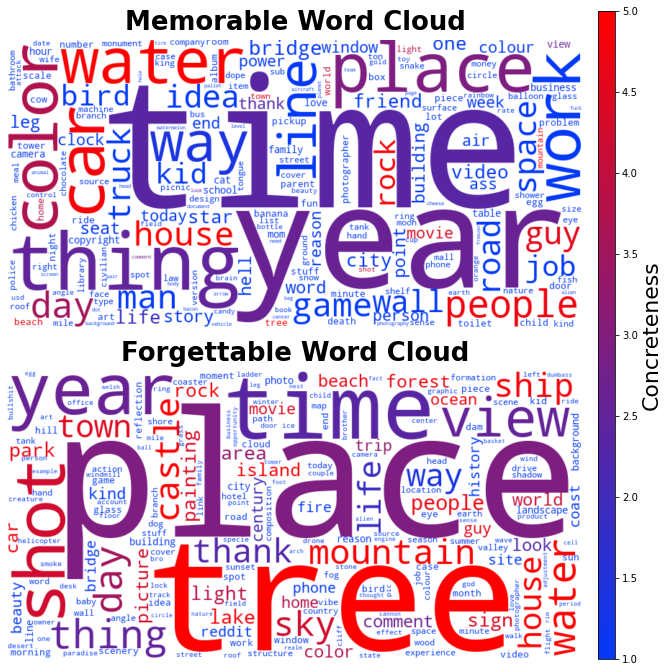

In [ ]:

fig = plt.figure(figsize=(12, 10))

# High Memorability Word Cloud
ax1 = fig.add_axes([0.05, 0.51, 0.7, 0.4])  # [left, bottom, width, height]
ax1.imshow(high_mem_wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Memorable Word Cloud', fontsize=26, fontweight = 'bold', pad=10)

# Low Memorability Word Cloud
ax2 = fig.add_axes([0.05, 0.05, 0.7, 0.4])  # [left, bottom, width, height]
ax2.imshow(low_mem_wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Forgettable Word Cloud', fontsize=26, fontweight = 'bold', pad=10)

# Create a color bar
norm = mcolors.Normalize(vmin=1, vmax=5)  # Normalized scores range from 0 to 1
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Adjust the position of the color bar
cax = fig.add_axes([0.75, 0.05, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Concreteness', fontsize = 22)
plt.show()

I have to first create a list of words for each image post, and then calculate the concreteness scores for each image. then I average the concreteness for each image. which is the dependent variable in here

In [ ]:
# Create a dictionary of words and their values
temp1 = high_mem_con[['word', 'concreteness']].reset_index(drop=True)
temp2 = low_mem_con[['word', 'concreteness']].reset_index(drop=True)
all_words_con = pd.concat([temp1, temp2])
all_con_df = all_words_con.drop_duplicates(subset=['word','concreteness'],keep='first')
all_con_dict = all_con_df.set_index('word')['concreteness'].to_dict()

In [ ]:
def calculate_avg_concreteness(words_list, con_dict):
    # Filter out any words that might not be in the dictionary
    scores = [con_dict[word] for word in words_list if word in con_dict]
    # Calculate average if scores are present, else return None or a default value
    return sum(scores) / len(scores) if scores else None

# Applying the function to each row in the DataFrame
words_df['avg_con'] = words_df['Words'].apply(lambda words: calculate_avg_concreteness(words, all_con_dict))

#### Consistency Analysis is stored in another ipynb file

In [ ]:
allcomment_labels = pd.read_csv('/Users/lucian/library/cloudstorage/box-box/memoMedia/reddit_Data/image_labels.csv')
comment_labels = allcomment_labels[allcomment_labels['Image Name'].isin(words_df['Image ID'])]

In [ ]:
import pandas as pd
import spacy
import contractions

# Initialize a new column for processed labels
comment_labels['Tokenized_labels'] = None

# Process each label
for index, row in comment_labels.iterrows():
    # Clean the data through cleaning functions
    label = clean_repetition(row['Labels'])
    
    # Process the label
    doc = nlp(label)
    
    filtered_lemmatized_words = [
        token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha
    ]
    # Store the list of words in the DataFrame
    comment_labels.at[index, 'Tokenized_labels'] = filtered_lemmatized_words
comment_labels = comment_labels.reset_index(drop=True)

/var/folders/l4/l90dznp92ns0myv_j37sn7fm0000gn/T/ipykernel_56466/1257421612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_labels['Tokenized_labels'] = None


In [ ]:
comment_labels_sorted = comment_labels.sort_values(by='Image Name').reset_index(drop=True)
words_df_sorted = words_df.sort_values(by='Image ID').reset_index(drop=True)

In [ ]:
consistency_df = pd.DataFrame({'imageID': words_df_sorted['Image ID'],
                            #    'C': overlapping_words_counts,
                            #   'T': words_df['Word Count'],
                              'memorability_scores': words_df_sorted['memorability scores'],
                              'comments': words_df_sorted['Words'],
                              'labels': comment_labels_sorted['Tokenized_labels']})

# consistency_df['score']= consistency_df['C']/consistency_df['T']
consistency_df.to_csv('consistency_df_new.csv')